In [1]:
### A Pluto.jl notebook ###
# v0.19.32

using Markdown
using InteractiveUtils

In [2]:
begin
	using Dates
	using CSV
	using DataFrames
	using DataFramesMeta
	using Chain
	using CairoMakie
end

In [3]:
using GLM, StatsBase

In [4]:
using Random

In [5]:
ENV["COLUMNS"] = 1000; # print more columns of tables

In [6]:
df = CSV.read("../data_dojo_22/Realisierte_Erzeugung_201501010000_202305301300_Stunde.csv",
    DataFrame,
    delim=";",
    decimal=',',
    groupmark='.',
    missingstring="-",
    dateformat=Dict("Datum"=>"dd.mm.yyyy"),
    types=Dict("Datum"=>Date)
);

In [7]:
begin
	clean_colname(x) = replace(split(x, " [")[1], " " => "_")
	clean_names = clean_colname.(names(df));
end

15-element Vector{String}:
 "Datum"
 "Anfang"
 "Ende"
 "Biomasse"
 "Wasserkraft"
 "Wind_Offshore"
 "Wind_Onshore"
 "Photovoltaik"
 "Sonstige_Erneuerbare"
 "Kernenergie"
 "Braunkohle"
 "Steinkohle"
 "Erdgas"
 "Pumpspeicher"
 "Sonstige_Konventionelle"

In [8]:
rename!(df, clean_names)

Row,Datum,Anfang,Ende,Biomasse,Wasserkraft,Wind_Offshore,Wind_Onshore,Photovoltaik,Sonstige_Erneuerbare,Kernenergie,Braunkohle,Steinkohle,Erdgas,Pumpspeicher,Sonstige_Konventionelle
,Date,Time,Time,Float64?,Float64?,Float64,Float64,Float64,Float64?,Float64,Float64?,Float64?,Float64?,Float64?,Float64?
1,2015-01-01,00:00:00,01:00:00,4024.25,1158.25,516.5,8128.0,0.0,133.0,10710.5,15687.2,3219.75,1226.25,1525.75,4909.25
2,2015-01-01,01:00:00,02:00:00,3982.75,1188.0,516.25,8297.5,0.0,122.5,11086.2,15321.8,2351.25,870.75,1079.25,4932.75
3,2015-01-01,02:00:00,03:00:00,4019.5,1139.25,514.0,8540.0,0.0,93.0,11026.2,14817.5,2227.0,809.5,787.0,5041.75
4,2015-01-01,03:00:00,04:00:00,4040.75,1122.5,517.75,8552.0,0.0,86.5,11027.8,14075.0,2339.75,821.0,287.75,5084.0
5,2015-01-01,04:00:00,05:00:00,4037.75,1112.0,519.75,8643.5,0.0,86.5,10962.2,14115.0,2461.5,831.25,346.75,5070.75
6,2015-01-01,05:00:00,06:00:00,4028.25,1107.75,520.0,8711.75,0.0,86.75,10696.0,13474.2,2217.75,851.0,765.5,5096.75
7,2015-01-01,06:00:00,07:00:00,4013.25,1111.75,521.5,9167.25,0.0,87.0,10299.5,12403.8,2373.25,868.25,414.5,5153.0
8,2015-01-01,07:00:00,08:00:00,4012.75,1113.75,520.25,9811.0,0.0,87.0,10035.2,12062.5,2491.0,876.0,582.5,5161.0
9,2015-01-01,08:00:00,09:00:00,3999.75,1107.5,525.25,9683.0,53.0,87.0,10245.8,12405.0,2530.25,888.25,750.5,5393.5


In [9]:
begin
	datetime_vec = Dates.DateTime.(df.Datum, df.Anfang);
	datetime_data = insertcols!(df,1, :Datetime => datetime_vec );
	datetime_clean = select(datetime_data, Not([:Datum, :Anfang, :Ende]));
end

Row,Datetime,Biomasse,Wasserkraft,Wind_Offshore,Wind_Onshore,Photovoltaik,Sonstige_Erneuerbare,Kernenergie,Braunkohle,Steinkohle,Erdgas,Pumpspeicher,Sonstige_Konventionelle
,DateTime,Float64?,Float64?,Float64,Float64,Float64,Float64?,Float64,Float64?,Float64?,Float64?,Float64?,Float64?
1,2015-01-01T00:00:00,4024.25,1158.25,516.5,8128.0,0.0,133.0,10710.5,15687.2,3219.75,1226.25,1525.75,4909.25
2,2015-01-01T01:00:00,3982.75,1188.0,516.25,8297.5,0.0,122.5,11086.2,15321.8,2351.25,870.75,1079.25,4932.75
3,2015-01-01T02:00:00,4019.5,1139.25,514.0,8540.0,0.0,93.0,11026.2,14817.5,2227.0,809.5,787.0,5041.75
4,2015-01-01T03:00:00,4040.75,1122.5,517.75,8552.0,0.0,86.5,11027.8,14075.0,2339.75,821.0,287.75,5084.0
5,2015-01-01T04:00:00,4037.75,1112.0,519.75,8643.5,0.0,86.5,10962.2,14115.0,2461.5,831.25,346.75,5070.75
6,2015-01-01T05:00:00,4028.25,1107.75,520.0,8711.75,0.0,86.75,10696.0,13474.2,2217.75,851.0,765.5,5096.75
7,2015-01-01T06:00:00,4013.25,1111.75,521.5,9167.25,0.0,87.0,10299.5,12403.8,2373.25,868.25,414.5,5153.0
8,2015-01-01T07:00:00,4012.75,1113.75,520.25,9811.0,0.0,87.0,10035.2,12062.5,2491.0,876.0,582.5,5161.0
9,2015-01-01T08:00:00,3999.75,1107.5,525.25,9683.0,53.0,87.0,10245.8,12405.0,2530.25,888.25,750.5,5393.5


In [10]:
begin
	train = filter(:Datetime => <(Dates.Date(2021)), datetime_clean);
	val = filter(:Datetime => d -> Dates.year(d)==2021, datetime_clean);
	test = filter(:Datetime => >(Dates.Date(2021)), datetime_clean);
end

Row,Datetime,Biomasse,Wasserkraft,Wind_Offshore,Wind_Onshore,Photovoltaik,Sonstige_Erneuerbare,Kernenergie,Braunkohle,Steinkohle,Erdgas,Pumpspeicher,Sonstige_Konventionelle
,DateTime,Float64?,Float64?,Float64,Float64,Float64,Float64?,Float64,Float64?,Float64?,Float64?,Float64?,Float64?
1,2021-01-01T01:00:00,4584.25,1196.25,394.5,3541.5,0.0,227.0,8150.25,11602.8,3044.75,5409.0,518.5,1636.25
2,2021-01-01T02:00:00,4581.25,1164.0,305.25,3217.0,0.0,227.0,8156.5,11758.5,3067.25,5312.0,219.0,1630.5
3,2021-01-01T03:00:00,4570.75,1179.25,319.25,2787.5,0.0,227.0,8153.75,12337.5,2852.5,5127.0,2.0,1622.0
4,2021-01-01T04:00:00,4571.0,1155.0,296.25,2492.5,0.0,231.75,8150.5,12395.0,2713.25,4993.0,6.0,1621.75
5,2021-01-01T05:00:00,4589.25,1145.5,432.0,2140.75,0.0,231.25,8150.25,12699.5,2736.5,5057.5,33.5,1650.0
6,2021-01-01T06:00:00,4628.25,1160.5,510.25,2010.75,0.0,232.75,8154.5,13051.0,2836.5,5094.0,89.75,1661.25
7,2021-01-01T07:00:00,4693.0,1157.5,389.25,1975.0,0.0,232.0,8152.75,12472.5,2952.0,5169.25,926.25,1661.25
8,2021-01-01T08:00:00,4766.25,1152.25,359.5,2087.5,194.0,232.0,8157.5,12435.8,3087.25,5569.25,80.5,1648.5
9,2021-01-01T09:00:00,4764.75,1163.5,248.25,2123.5,1363.75,231.0,8160.0,12169.5,3085.0,6052.5,124.75,1652.25


In [11]:
size(train), size(val), size(test)

((52608, 13), (8760, 13), (21107, 13))

In [12]:
data_y = @chain train begin
    @transform(:Year = Dates.year.(:Datetime))
    groupby(:Year)
    @combine(:Biomasse = sum(:Biomasse), :Wasserkraft = sum(:Wasserkraft), :Wind_Offshore = sum(:Wind_Offshore), :Wind_Onshore = sum(:Wind_Onshore), :Photovoltaik = sum(:Photovoltaik), :Sonstige_Erneuerbare = sum(:Sonstige_Erneuerbare), :Kernenergie = sum(:Kernenergie), :Braunkohle = sum(:Braunkohle) ,:Steinkohle = sum(:Steinkohle), :Erdgas = sum(:Erdgas), :Pumpspeicher = sum(:Pumpspeicher), :Sonstige_Konventionelle = sum(:Sonstige_Konventionelle))
end

Row,Year,Biomasse,Wasserkraft,Wind_Offshore,Wind_Onshore,Photovoltaik,Sonstige_Erneuerbare,Kernenergie,Braunkohle,Steinkohle,Erdgas,Pumpspeicher,Sonstige_Konventionelle
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2015,3.48479e7,1.37193e7,8.13438e6,6.90421e7,3.48794e7,9.4563e5,8.43635e7,1.33798e8,8.11387e7,1.52259e7,9.93722e6,5.29686e7
2,2016,3.97455e7,1.80759e7,1.20931e7,6.52747e7,3.45389e7,1.40346e6,8.02425e7,1.30376e8,8.089e7,2.28888e7,8.58761e6,4.73436e7
3,2017,4.03284e7,1.55901e7,1.74142e7,8.51901e7,3.58832e7,1.75439e6,7.2214e7,1.29287e8,6.60055e7,2.55804e7,9.29078e6,4.87431e7
4,2018,4.00905e7,1.52577e7,1.90684e7,8.92706e7,4.12343e7,1.53113e6,7.18417e7,1.28362e8,7.15453e7,4.28782e7,9.13598e6,1.2838e7
5,2019,4.03876e7,1.58305e7,2.43828e7,9.98789e7,4.19148e7,1.46438e6,7.10422e7,1.02729e8,4.78153e7,5.46197e7,9.02058e6,1.27306e7
6,2020,4.08223e7,1.55834e7,2.68832e7,1.03104e8,4.58216e7,1.60774e6,6.09239e7,8.3374e7,3.4872e7,5.9126e7,1.15287e7,1.29299e7


In [13]:
begin
	photovoltaic_train = select(train, :Datetime, :Photovoltaik)
	photovoltaic_val = select(val, :Datetime, :Photovoltaik)
end

Row,Datetime,Photovoltaik
,DateTime,Float64
1,2021-01-01T00:00:00,0.0
2,2021-01-01T01:00:00,0.0
3,2021-01-01T02:00:00,0.0
4,2021-01-01T03:00:00,0.0
5,2021-01-01T04:00:00,0.0
6,2021-01-01T05:00:00,0.0
7,2021-01-01T06:00:00,0.0
8,2021-01-01T07:00:00,0.0
9,2021-01-01T08:00:00,194.0


In [14]:
# kills the kernel with out of memory
# ols = lm(@formula(Photovoltaik ~ Datetime), photovoltaic_train)

In [15]:
dumb_estimate = photovoltaic_train[!,:Photovoltaik] |> x -> mean(x)

4453.166181949513

In [16]:
error_dumb_estimate = mean(abs.(photovoltaic_val[!,:Photovoltaik] .- dumb_estimate))

6217.043334561944

In [17]:
function estimate_me(df, datetime)
	return df[!,:Photovoltaik] |> x -> mean(x)
end

estimate_me (generic function with 1 method)

In [18]:
function error(df, range_of_datetimes, val)
	estimates = estimate.(df, range_of_datetimes)
	return mean(abs.(val[!,:Photovoltaik] .- estimates))
end

error (generic function with 1 method)

In [19]:
estimate_me(photovoltaic_train, 0)

4453.166181949513

In [21]:
# vectorization does not work as the first argument will be vectorized as well
#estimate_me.(photovoltaic_train, [0,1,2])

In [35]:
dumb_estimates = repeat([dumb_estimate], size(val)[1]);

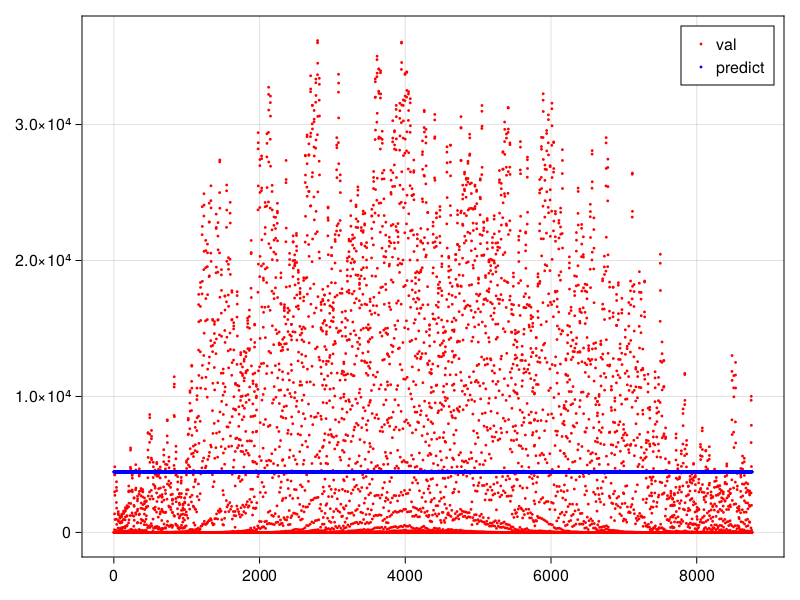

In [36]:
fig = Figure()
ax = Axis(fig[1,1])
scatter!(ax,val.Photovoltaik, color = "red", label = "val", markersize = 4)
scatter!(ax, dumb_estimates, color = "blue", label = "predict",markersize = 4)
axislegend(ax)
fig

In [22]:
nm = ["Robin", "Sabine", "Dharu"]

3-element Vector{String}:
 "Robin"
 "Sabine"
 "Dharu"

In [23]:
rand(nm)

"Dharu"

In [24]:
lg = ["Jl1", "Jl2", "Py"]

3-element Vector{String}:
 "Jl1"
 "Jl2"
 "Py"

In [25]:
Random.shuffle(lg)

3-element Vector{String}:
 "Py"
 "Jl1"
 "Jl2"